<a href="https://colab.research.google.com/github/adarshukla3005/Stock_sentiment_analysis/blob/main/NVidia_stock_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Web Scaping from Financial times website

In [ ]:
import requests
from bs4 import BeautifulSoup
import time

def get_ft_nvidia_headlines(pages=50):
    headlines = []
    base_url = "https://www.ft.com/search?q=NVIDIA&page={}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    for page in range(1, pages + 1):
        url = base_url.format(page)
        response = requests.get(url, headers=headers)

        # Check if the request was successful
        if response.status_code != 200:
            print(f"Failed to fetch page {page}. Status code: {response.status_code}")
            continue

        soup = BeautifulSoup(response.content, "html.parser")

        for item in soup.find_all('div', class_='o-teaser__content'):
            headline_tag = item.find('a', class_='js-teaser-heading-link')
            date_tag = item.find('time', class_='o-teaser__timestamp-date')

            if headline_tag and date_tag:
                headline = headline_tag.get_text().strip()
                date = date_tag.get_text().strip()
                headlines.append((headline, date))

        # Be respectful with a short delay to avoid overwhelming the server
        time.sleep(2)

    return headlines

# Fetch and print FT news headlines related to NVIDIA for 50 pages
ft_nvidia_headlines = get_ft_nvidia_headlines(pages=50)
for headline, date in ft_nvidia_headlines:
    print(f"Headline: {headline}\nDate: {date}\n")

Failed to fetch page 41. Status code: 400
Failed to fetch page 42. Status code: 400
Failed to fetch page 43. Status code: 400
Failed to fetch page 44. Status code: 400
Failed to fetch page 45. Status code: 400
Failed to fetch page 46. Status code: 400
Failed to fetch page 47. Status code: 400
Failed to fetch page 48. Status code: 400
Failed to fetch page 49. Status code: 400
Failed to fetch page 50. Status code: 400
Headline: Amazon changes plans to order Nvidia ‘superchip’ to await updated model
Date: May 21, 2024

Headline: Record rally for US stocks pauses even as heavyweight Nvidia advances
Date: June 14, 2024

Headline: US stocks slip as Nvidia falls
Date: June 6, 2024

Headline: GameStop and Nvidia help lift US stock indices
Date: June 3, 2024

Headline: Nvidia shares steady after Thursday’s rally
Date: May 24, 2024

Headline: US stocks slip despite Nvidia surge
Date: May 23, 2024

Headline: Nvidia’s market value crosses $3tn for the first time
Date: June 5, 2024

Headline: Samsu

In [ ]:
import pandas as pd
df = pd.DataFrame(ft_nvidia_headlines, columns=['Headline',  'Date'])

In [ ]:
df

,Headline,Date
0,Amazon changes plans to order Nvidia ‘superchi...,"May 21, 2024"
1,Record rally for US stocks pauses even as heav...,"June 14, 2024"
2,US stocks slip as Nvidia falls,"June 6, 2024"
3,GameStop and Nvidia help lift US stock indices,"June 3, 2024"
4,Nvidia shares steady after Thursday’s rally,"May 24, 2024"
...,...,...
984,Microsoft’s $75bn gaming gambit on the brink a...,"April 26, 2023"
985,Microsoft plans mobile games app store to riva...,"March 20, 2023"
986,"Big Tech, narrow market","June 1, 2023"
987,Who’s taking over Silvio Berlusconi’s €4bn emp...,"June 16, 2023"


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

# Sort DataFrame by 'Date'
df = df.sort_values(by='Date')

# Group by 'Date' and combine headlines
grouped_df = df.groupby('Date').agg({'Headline': ' | '.join}).reset_index()

In [ ]:
grouped_df

,Date,Headline
0,2022-05-25,Nvidia blames China lockdowns and Russia’s war...
1,2022-08-08,Nvidia hit by weakness in gaming revenue
2,2022-09-01,Nvidia: metaverse chipmaker gets reality check...
3,2022-09-02,Cruise control: port cities push back against ...
4,2022-09-22,SoftBank to meet Samsung to explore Arm ‘strat...
...,...,...
333,2024-06-13,How AI may become the new offshoring | Leverag...
334,2024-06-14,Cryptofinance: chasing an AI dream | Letter: A...
335,2024-06-15,"Naomi Klein, an activist writer stalked by con..."
336,2024-06-16,Transcript: Martin Wolf and Raghuram Rajan on ...


Fetch NVIDIA stock data
Correlation between Sentiment and Price change

In [ ]:
pip install pandas yfinance vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.7 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Create a DataFrame
df = pd.DataFrame(ft_nvidia_headlines, columns=['Headline', 'Date'])

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort DataFrame by 'Date'
df = df.sort_values(by='Date')

# Group by 'Date' and combine headlines
grouped_df = df.groupby('Date').agg({'Headline': ' | '.join}).reset_index()

# Fetch NVIDIA stock data using yfinance
start_date = grouped_df['Date'].min()
end_date = grouped_df['Date'].max()
nvda_data = yf.download('NVDA', start=start_date, end=end_date)

# Reset index to make 'Date' a column
nvda_data.reset_index(inplace=True)

# Merge the stock data with the grouped_df on the 'Date' column
merged_df = pd.merge(grouped_df, nvda_data, on='Date', how='left')

# Label stock price movements
merged_df['Price Movement'] = merged_df['Close'].diff().shift(-1)
merged_df['Price Movement'] = merged_df['Price Movement'].apply(lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'No Change'))

# Drop rows with NaN values created by shift
merged_df = merged_df.dropna(subset=['Price Movement'])

# Perform sentiment analysis on the headlines
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(headline):
    vs = analyzer.polarity_scores(headline)
    return vs['compound']

merged_df['Sentiment'] = merged_df['Headline'].apply(analyze_sentiment)

# Calculate daily percentage change in stock price
merged_df['Price Change'] = merged_df['Close'].pct_change()

# Display the DataFrame with sentiment scores and price changes
print(merged_df[['Date', 'Headline', 'Sentiment', 'Price Change']])

# Calculate correlation between sentiment and stock price change
correlation = merged_df[['Sentiment', 'Price Change']].corr()
print("Correlation between sentiment and stock price change:")
print(correlation)

[*********************100%%**********************]  1 of 1 completed

          Date                                           Headline  Sentiment  \
0   2022-05-25  Nvidia blames China lockdowns and Russia’s war...    -0.8591   
1   2022-08-08           Nvidia hit by weakness in gaming revenue    -0.4215   
2   2022-09-01  Nvidia: metaverse chipmaker gets reality check...    -0.7351   
3   2022-09-02  Cruise control: port cities push back against ...     0.0000   
4   2022-09-22  SoftBank to meet Samsung to explore Arm ‘strat...     0.0000   
..         ...                                                ...        ...   
333 2024-06-13  How AI may become the new offshoring | Leverag...     0.1531   
334 2024-06-14  Cryptofinance: chasing an AI dream | Letter: A...     0.2500   
335 2024-06-15  Naomi Klein, an activist writer stalked by con...     0.0000   
336 2024-06-16  Transcript: Martin Wolf and Raghuram Rajan on ...    -0.4019   
337 2024-06-17   The bullish case for TSMC | The top-heavy market     0.0000   

     Price Change  
0             NaN  

Label the stock Movement

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np


# Label stock price movements
merged_df['Price Movement'] = merged_df['Close'].diff().shift(-1)
merged_df['Price Movement'] = merged_df['Price Movement'].apply(lambda x: 1 if x > 0 else 0)

# Drop rows with NaN values created by shift
merged_df = merged_df.dropna(subset=['Price Movement'])

# Perform sentiment analysis on the headlines
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(headline):
    vs = analyzer.polarity_scores(headline)
    return vs['compound']

merged_df['Sentiment'] = merged_df['Headline'].apply(analyze_sentiment)

# Display the DataFrame with sentiment scores and price movements
print(merged_df[['Date', 'Headline', 'Sentiment', 'Price Movement']])

          Date                                           Headline  Sentiment  \
0   2022-05-25  Nvidia blames China lockdowns and Russia’s war...    -0.8591   
1   2022-08-08           Nvidia hit by weakness in gaming revenue    -0.4215   
2   2022-09-01  Nvidia: metaverse chipmaker gets reality check...    -0.7351   
3   2022-09-02  Cruise control: port cities push back against ...     0.0000   
4   2022-09-22  SoftBank to meet Samsung to explore Arm ‘strat...     0.0000   
..         ...                                                ...        ...   
333 2024-06-13  How AI may become the new offshoring | Leverag...     0.1531   
334 2024-06-14  Cryptofinance: chasing an AI dream | Letter: A...     0.2500   
335 2024-06-15  Naomi Klein, an activist writer stalked by con...     0.0000   
336 2024-06-16  Transcript: Martin Wolf and Raghuram Rajan on ...    -0.4019   
337 2024-06-17   The bullish case for TSMC | The top-heavy market     0.0000   

     Price Movement  
0                

Model: Logistic Regression
Accuracy: 0.6176
Precision: 0.5606
Recall: 0.5073
F1-score: 0.4153
ROC AUC: 0.4881




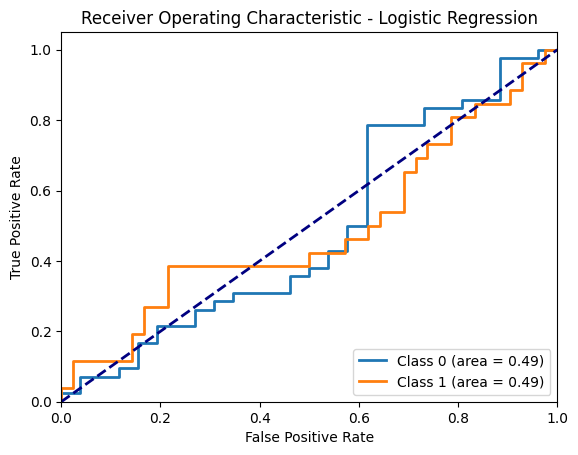

Model: Support Vector Machine
Accuracy: 0.6324
Precision: 0.8134
Recall: 0.5192
F1-score: 0.4224
ROC AUC: 0.4863




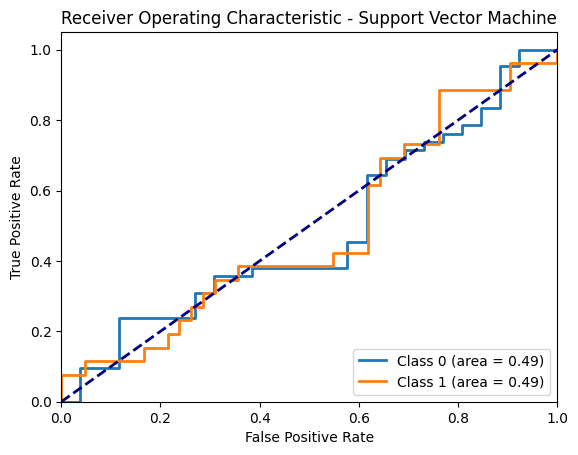

Model: Random Forest
Accuracy: 0.6029
Precision: 0.5258
Recall: 0.5101
F1-score: 0.4598
ROC AUC: 0.4712




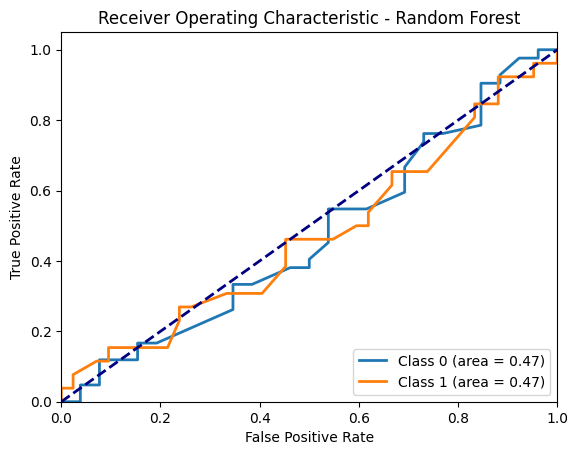

Model: Neural Network
Accuracy: 0.5294
Precision: 0.4771
Recall: 0.4799
F1-score: 0.4744
ROC AUC: 0.4625




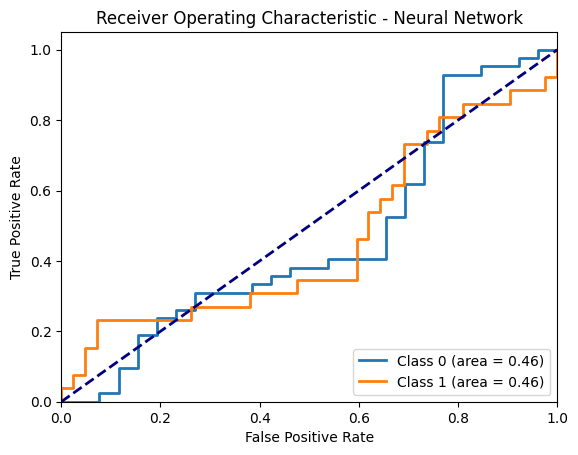

In [ ]:
# Use TF-IDF Vectorizer to convert textual data to numerical data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_text = tfidf_vectorizer.fit_transform(merged_df['Headline'])

# Combine text features with sentiment score
X = pd.DataFrame(X_text.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X['Sentiment'] = merged_df['Sentiment'].values

# Define target variable
y = merged_df['Price Movement']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(max_iter=500)
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test) if hasattr(clf, "predict_proba") else clf.decision_function(X_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    if y_proba.ndim == 1:
        y_proba = y_proba.reshape(-1, 1)

    # Binarize the output labels for ROC AUC calculation
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_binarized = lb.transform(y_test)

    if y_test_binarized.shape[1] == 1:
        y_test_binarized = np.hstack((1 - y_test_binarized, y_test_binarized))

    roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovo', average='macro')

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\n")

    # Plot ROC curve
    fpr = {}
    tpr = {}
    roc_auc_dict = {}
    for i in range(y_test_binarized.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(y_test_binarized.shape[1]):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc_dict[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {name}')
    plt.legend(loc="lower right")
    plt.show()

Buy/Sell Signals and Portfolio value over time

In [ ]:
print(merged_df.columns)

Index(['Date', 'Headline', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume', 'Price Movement', 'Sentiment', 'Price Change'],
      dtype='object')


[*********************100%%**********************]  1 of 1 completed


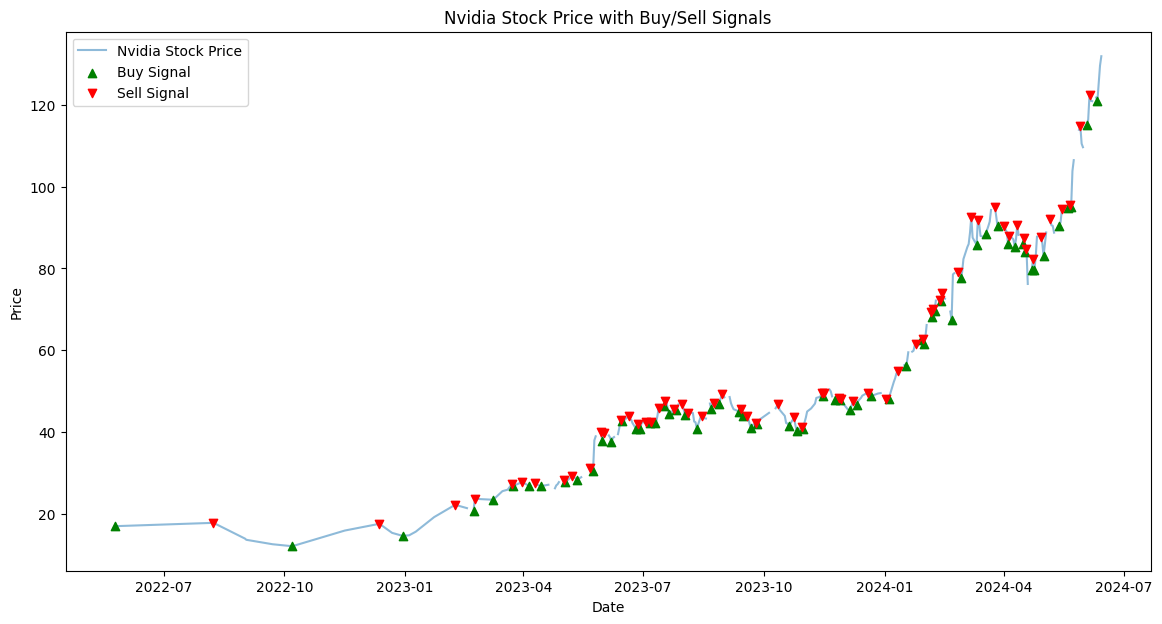

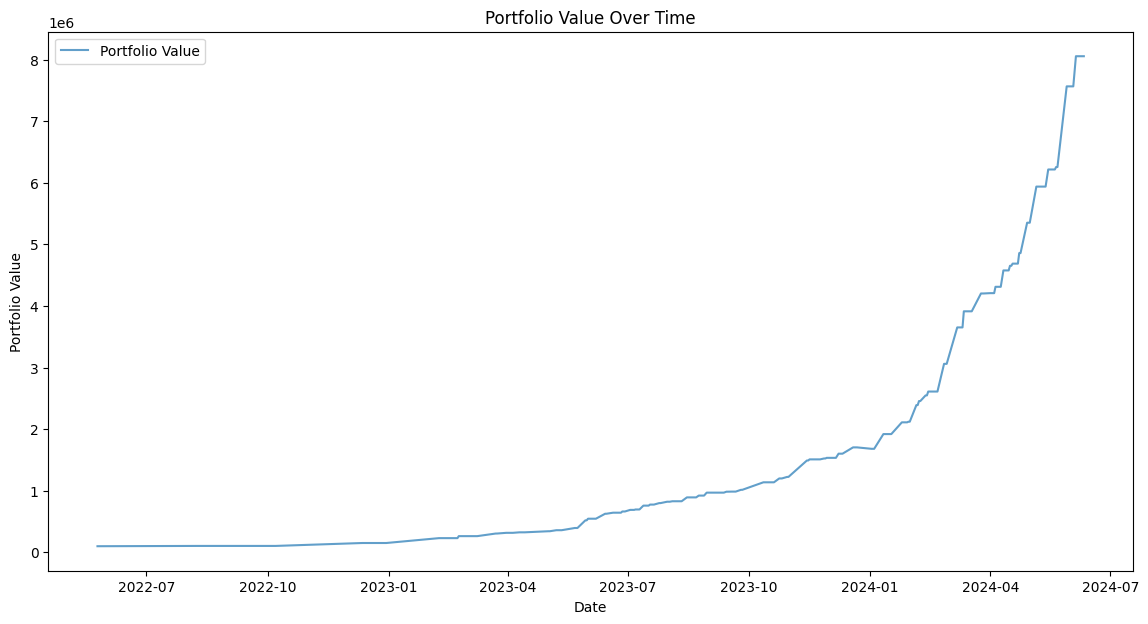

In [ ]:
# Import necessary libraries
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import yfinance as yf
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# # Function to get FT Nvidia headlines
# def get_ft_nvidia_headlines(pages=100):
#     headlines = []
#     base_url = "https://www.ft.com/search?q=Nvidia&page={}"
#     headers = {
#         "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
#     }

#     for page in range(1, pages + 1):
#         url = base_url.format(page)
#         response = requests.get(url, headers=headers)
#         soup = BeautifulSoup(response.content, "html.parser")

#         for item in soup.find_all('div', class_='o-teaser__content'):
#             headline_tag = item.find('a', class_='js-teaser-heading-link')
#             date_tag = item.find('time', class_='o-teaser__timestamp-date')

#             if headline_tag and date_tag:
#                 headline = headline_tag.get_text().strip()
#                 date = date_tag.get_text().strip()
#                 headlines.append((headline, date))

#         time.sleep(2)

#     return headlines

# # Fetch FT news headlines related to Nvidia for 100 pages
# ft_nvidia_headlines = get_ft_nvidia_headlines(pages=100)

# # Create a DataFrame
# df = pd.DataFrame(ft_nvidia_headlines, columns=['Headline', 'Date'])

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort DataFrame by 'Date'
df = df.sort_values(by='Date')

# Group by 'Date' and combine headlines
grouped_df = df.groupby('Date').agg({'Headline': ' | '.join}).reset_index()

# Fetch Nvidia stock data using yfinance
start_date = grouped_df['Date'].min()
end_date = grouped_df['Date'].max()
nvda_data = yf.download('NVDA', start=start_date, end=end_date)

# Reset index to make 'Date' a column
nvda_data.reset_index(inplace=True)

# Merge the stock data with the grouped_df on the 'Date' column
merged_df = pd.merge(grouped_df, nvda_data, on='Date', how='left')

# Label stock price movements
merged_df['Price Movement'] = merged_df['Close'].diff().shift(-1)
merged_df['Price Movement'] = merged_df['Price Movement'].apply(lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'No Change'))

# Drop rows with NaN values created by shift
merged_df = merged_df.dropna(subset=['Price Movement'])

# Perform sentiment analysis on the headlines
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(headline):
    vs = analyzer.polarity_scores(headline)
    return vs['compound']

merged_df['Sentiment'] = merged_df['Headline'].apply(analyze_sentiment)

# Use TF-IDF Vectorizer to convert textual data to numerical data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_text = tfidf_vectorizer.fit_transform(merged_df['Headline'])

# Combine text features with sentiment score
X = pd.DataFrame(X_text.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X['Sentiment'] = merged_df['Sentiment'].values

# Define target variable
y = merged_df['Price Movement']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier(max_iter=500)
}

# Choose the classifier you want to use
clf = classifiers['Random Forest']
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Generate trading signals based on predictions
merged_df['Signal'] = clf.predict(X)

# Simulate trading strategy
initial_capital = 100000
capital = initial_capital
position = 0
portfolio = []

for i, row in merged_df.iterrows():
    if row['Price Movement'] == 'Increase' and position == 0:
        position = capital / row['Close']
        capital = 0
        portfolio.append((row['Date'], 'BUY', row['Close'], position, capital + position * row['Close']))
    elif row['Price Movement'] == 'Decrease' and position > 0:
        capital = position * row['Close']
        position = 0
        portfolio.append((row['Date'], 'SELL', row['Close'], position, capital))

portfolio_df = pd.DataFrame(portfolio, columns=['Date', 'Action', 'Price', 'Position', 'Portfolio Value'])

# Plot the stock price and buy/sell signals
plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['Close'], label='Nvidia Stock Price', alpha=0.5)
buy_signals = portfolio_df[portfolio_df['Action'] == 'BUY']
sell_signals = portfolio_df[portfolio_df['Action'] == 'SELL']
plt.scatter(buy_signals['Date'], buy_signals['Price'], marker='^', color='g', label='Buy Signal', alpha=1, zorder=3)
plt.scatter(sell_signals['Date'], sell_signals['Price'], marker='v', color='r', label='Sell Signal', alpha=1, zorder=3)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Nvidia Stock Price with Buy/Sell Signals')
plt.legend()
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(portfolio_df['Date'], portfolio_df['Portfolio Value'], label='Portfolio Value', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()